In [23]:
import pandas as pd
import requests
from dotenv import load_dotenv
from sql_functions import get_engine
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import time
import json
load_dotenv()

True

NameError: name 'json' is not defined

## 2012!

In [24]:
#Weather data for 2012
#API URL and headers
#Weather data for 2011
url = 'https://meteostat.p.rapidapi.com/point/daily'
headers = {
   "x-rapidapi-host": 'meteostat.p.rapidapi.com',
   "x-rapidapi-key": os.getenv('x-rapidapi-key')  # Ensure this environment variable is set
}

#airports and their coordinates
airports = {
    "JFK": {"lat": 40.6413, "lon": -73.7781},  # John F. Kennedy International Airport
    "LGA": {"lat": 40.7769, "lon": -73.8740},  # LaGuardia Airport
    "EWR": {"lat": 40.6895, "lon": -74.1745},  # Newark Liberty International Airport
    "PHL": {"lat": 39.8729, "lon": -75.2437},  # Philadelphia International Airport
    "BOS": {"lat": 42.3656, "lon": -71.0096},  # Boston Logan International Airport
    "DCA": {"lat": 38.8512, "lon": -77.0402},  # Ronald Reagan Washington National Airport
    "IAD": {"lat": 38.9531, "lon": -77.4565},  # Washington Dulles International Airport
    "BWI": {"lat": 39.1754, "lon": -76.6684}   # Baltimore/Washington International Thurgood Marshall Airport
}

#date range
start_date = "2012-10-01"
end_date = "2012-11-30"
weather_data_2012 = []

for airport_code, coordinates in airports.items():
    parameters = {
        "lat": coordinates["lat"],
        "lon": coordinates["lon"],
        "start": start_date,
        "end": end_date,
        "units": "metric"
    }
    time.sleep(1) 
    response = requests.get(url, headers=headers, params=parameters)

    if response.status_code == 200:
        data = response.json()
        for daily_data in data['data']:
            daily_data['airport_code'] = airport_code
            weather_data_2012.append(daily_data)
    else:
        print(f"Error fetching data for {airport_code}: {response.status_code} - {response.text}") 

#list of dictionaries to a DataFrame
weather_df_2012 = pd.DataFrame(weather_data_2012)


print(weather_df_2012.head())

         date  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
0  2012-10-01  17.1  12.2  22.2   0.0   0.0  262.0  18.4  None  1012.2  None   
1  2012-10-02  18.9  17.2  21.7   8.4   0.0    NaN   9.4  None  1015.8  None   
2  2012-10-03  20.3  18.3  23.3   0.0   0.0    NaN   6.1  None  1017.7  None   
3  2012-10-04  20.8  19.4  23.9  10.4   0.0    NaN   5.4  None  1019.3  None   
4  2012-10-05  20.7  16.1  25.0   0.0   0.0    NaN  12.6  None  1016.8  None   

  airport_code  
0          JFK  
1          JFK  
2          JFK  
3          JFK  
4          JFK  


In [26]:
#Cleaning steps for 2012
#Dropping empty columns
weather_df_2012 = weather_df_2012.drop(columns=['wpgt', 'tsun'])

#Filling missing values in wspd with 0
weather_df_2012['wspd'].fillna(0, inplace=True)

#Convert date column to datetime
weather_df_2012['date'] = pd.to_datetime(weather_df_2012['date']) 

In [27]:
weather_df_2012.airport_code.unique()

array(['JFK', 'LGA', 'EWR', 'PHL', 'BOS', 'DCA', 'IAD', 'BWI'],
      dtype=object)

In [28]:
weather_df_2012

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,airport_code
0,2012-10-01,17.1,12.2,22.2,0.0,0.0,262.0,18.4,1012.2,JFK
1,2012-10-02,18.9,17.2,21.7,8.4,0.0,NaN,9.4,1015.8,JFK
2,2012-10-03,20.3,18.3,23.3,0.0,0.0,NaN,6.1,1017.7,JFK
3,2012-10-04,20.8,19.4,23.9,10.4,0.0,NaN,5.4,1019.3,JFK
4,2012-10-05,20.7,16.1,25.0,0.0,0.0,NaN,12.6,1016.8,JFK
...,...,...,...,...,...,...,...,...,...,...
483,2012-11-26,3.9,-3.9,12.2,0.0,0.0,NaN,4.3,1020.5,BWI
484,2012-11-27,4.0,0.0,5.6,5.3,0.0,NaN,9.0,1022.9,BWI
485,2012-11-28,3.2,-2.8,7.8,0.0,0.0,NaN,9.4,1025.5,BWI
486,2012-11-29,2.6,-3.3,9.4,0.0,0.0,NaN,6.1,1028.8,BWI


In [54]:
average_wind_speed = weather_df_2012.groupby('date')['wspd'].mean().reset_index()

In [ ]:
# Write records stored in a dataframe to SQL database
table_name = 'weather_data_2012'
schema = 'cgn_analytics_24_3'
engine = get_engine()

if engine!=None:
    try:
        weather_df_2012.to_sql(table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # your class schema
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The weather_data_2012 table was imported successfully.


## Hurricane Sandy cities

In [29]:
#Weather data for 2012 - cities
#API URL and headers
#Weather data for 2011
url = 'https://meteostat.p.rapidapi.com/point/daily'
headers = {
   "x-rapidapi-host": 'meteostat.p.rapidapi.com',
   "x-rapidapi-key": os.getenv('x-rapidapi-key')  # Ensure this environment variable is set
}

#airports and their coordinates
cities = {
    "Kingston": {"lat": 17.9970, "lon": -76.7936},  
    "Cuba": {"lat": 21.5218, "lon": -77.7812},  
    "New Jersey": {"lat": 40.0583, "lon": -74.4057},  
    "New York": {"lat": 40.7128, "lon": -74.0060},  
    "Boston": {"lat": 42.3601, "lon": -71.0589},  
    "Philadelphia": {"lat": 39.9526, "lon": -75.1652},  
    "Washington DC": {"lat": 38.9072, "lon": -77.0369},  
    "Pennsylvania": {"lat": 41.2033, "lon": -77.1945}   
}

#date range
start_date = "2012-10-01"
end_date = "2012-11-30"
weather_city_data_2012 = []

for city, coordinates in cities.items():
    parameters = {
        "lat": coordinates["lat"],
        "lon": coordinates["lon"],
        "start": start_date,
        "end": end_date,
        "units": "metric"
    }
    time.sleep(1) 
    response = requests.get(url, headers=headers, params=parameters)

    if response.status_code == 200:
        data = response.json()
        for daily_data in data['data']:
            daily_data['city'] = city
            weather_city_data_2012.append(daily_data)
    else:
        print(f"Error fetching data for {city}: {response.status_code} - {response.text}") 

#list of dictionaries to a DataFrame
weather_cities_2012 = pd.DataFrame(weather_city_data_2012)
weather_cities_2012 = weather_cities_2012.dropna(subset=['wdir'])


print(weather_cities_2012.head())

          date  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt  pres  tsun  \
30  2012-10-31  27.6  25.0  32.0   NaN   NaN  352.0  16.5  None   NaN  None   
31  2012-11-01  27.8  25.1  31.6   NaN   NaN   11.0  14.4  None   NaN  None   
32  2012-11-02  27.8  25.1  31.6   NaN   NaN   21.0  16.6  None   NaN  None   
33  2012-11-03  28.1  24.6  32.2   NaN   NaN  348.0  15.0  None   NaN  None   
34  2012-11-04  28.1  24.9  32.2   NaN   NaN  344.0  12.5  None   NaN  None   

        city  
30  Kingston  
31  Kingston  
32  Kingston  
33  Kingston  
34  Kingston  


In [ ]:
weather_cities_2012.wdir.unique()

array([ nan, 352.,  11.,  21., 348., 344.,  31., 305.,   2.,   1., 301.,
       241., 326.,   8., 356., 329., 306.,   5.,   7., 351., 345., 338.,
        18., 295., 270., 309., 340., 141.,  77.,  66.,  64.,  53.,  16.,
        39., 267., 322.,  24.,  37.,  50.,  61.,  45.,  20.,  51.,  47.,
        52., 347.,  13.,   3.,  41., 232.,  19., 298., 287., 216., 228.,
       168.,  62.,  63.,  56.,  32.,  44., 173., 265., 278., 307., 293.,
        17., 291., 255., 249., 244.,  25., 297., 260., 281., 206., 210.,
       312., 136., 271.,  34.,  97.,  79.,  35., 167., 219., 236., 269.,
       296., 300., 330.,  28., 328., 304., 313.,   4., 252.,  10., 303.,
       243., 242., 222., 258.,  70., 262., 283., 277., 207., 202., 105.,
       188., 282.,  78., 112., 299., 308., 333., 355., 195., 198.,  12.,
       357.,   9., 199., 264., 261., 339., 256., 359.,  84., 247., 290.,
       276., 220., 156.,  72.,  15., 164., 226., 251.,  38., 335., 331.,
       353.,  48.,  42.,  58.,  30., 289., 250., 31

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


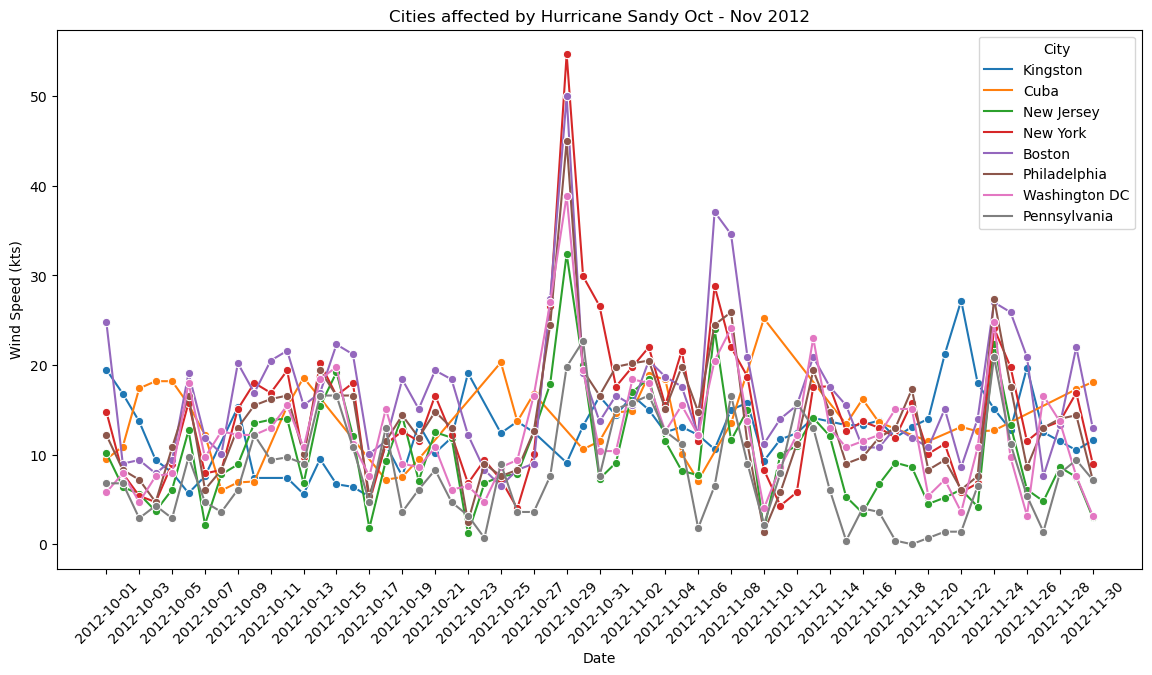

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_cities_2012, x='date', y='wspd', hue='city', marker='o')
plt.title('Cities affected by Hurricane Sandy Oct - Nov 2012')
plt.xlabel('Date')
plt.ylabel('Wind Speed (kts)')
dates = weather_cities_2012['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.legend(title='City')
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


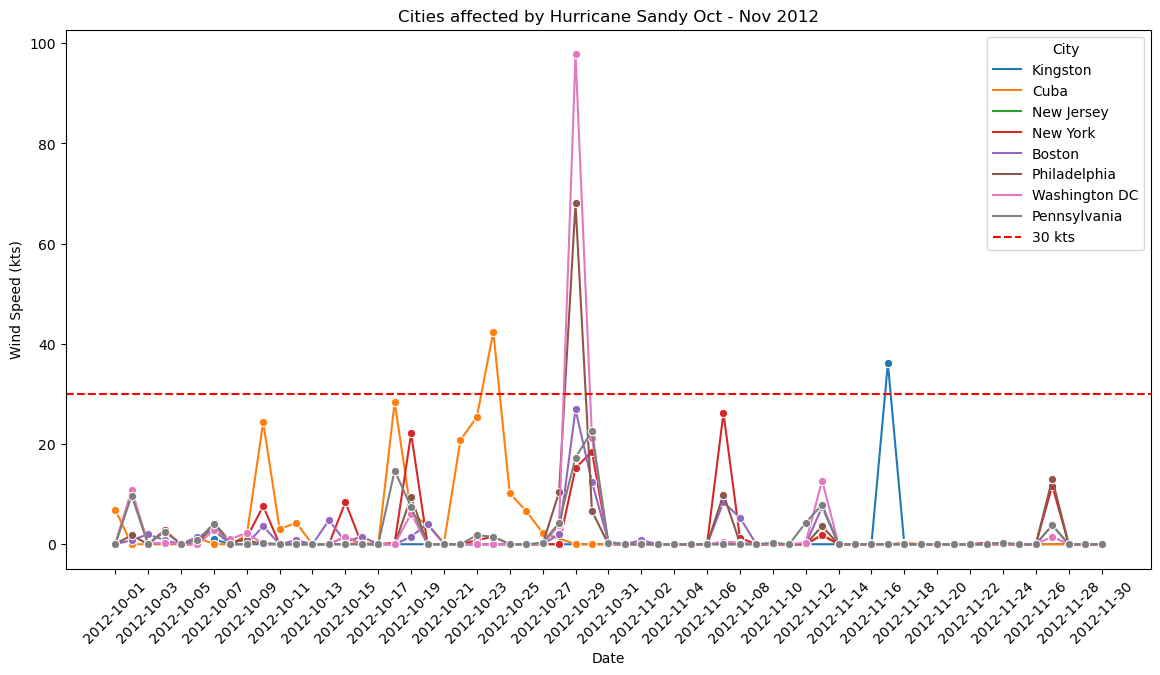

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_cities_2012, x='date', y='prcp', hue='city', marker='o')
plt.axhline(y=30, color='r', linestyle='--', label='30 kts')
plt.title('Cities affected by Hurricane Sandy Oct - Nov 2012')
plt.xlabel('Date')
plt.ylabel('Wind Speed (kts)')
dates = weather_cities_2012['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.legend(title='City')
plt.show()

In [ ]:
pip install windrose

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from windrose import WindroseAxes

In [ ]:
ny_data = weather_cities_2012[weather_cities_2012['city'] == 'New York']
kingston_data = weather_cities_2012[weather_cities_2012['city'] == 'Kingston']
cuba_data = weather_cities_2012[weather_cities_2012['city'] == 'Cuba']

<Figure size 1000x1000 with 0 Axes>

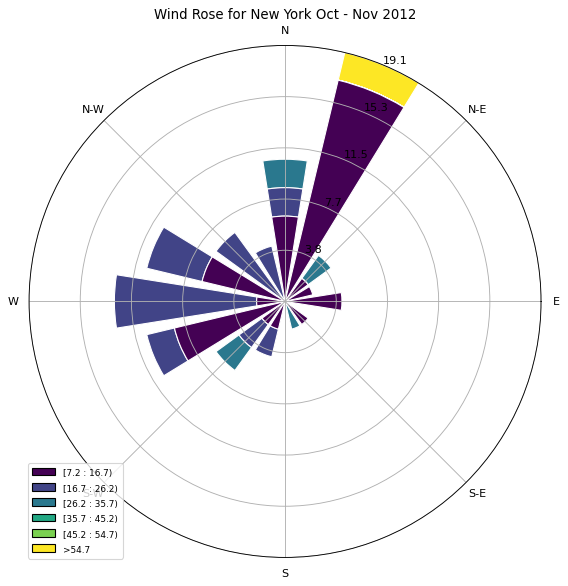

In [ ]:
plt.figure(figsize=(10, 10))
ax = WindroseAxes.from_ax()
ax.bar(ny_data['wdir'], ny_data['wspd'], normed=True, opening=0.8, edgecolor='white')
ax.set_title('Wind Rose for New York Oct - Nov 2012')
ax.set_legend()
plt.show()

<Figure size 1000x1000 with 0 Axes>

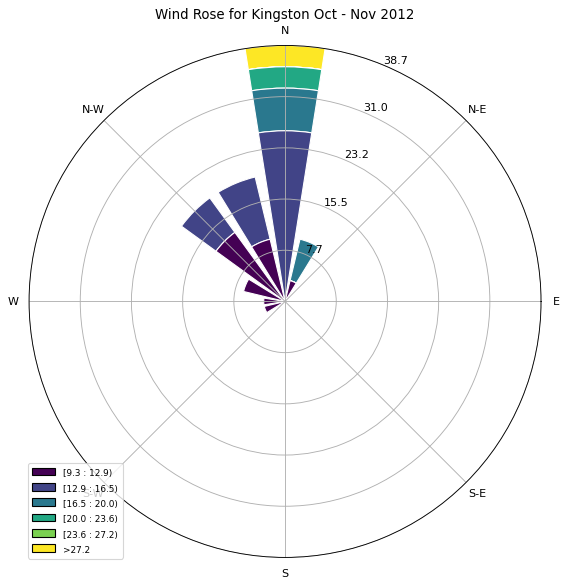

In [ ]:
plt.figure(figsize=(10, 10))
ax = WindroseAxes.from_ax()
ax.bar(kingston_data['wdir'], kingston_data['wspd'], normed=True, opening=0.8, edgecolor='white')
ax.set_title('Wind Rose for Kingston Oct - Nov 2012')
ax.set_legend()
plt.show()

<Figure size 1000x1000 with 0 Axes>

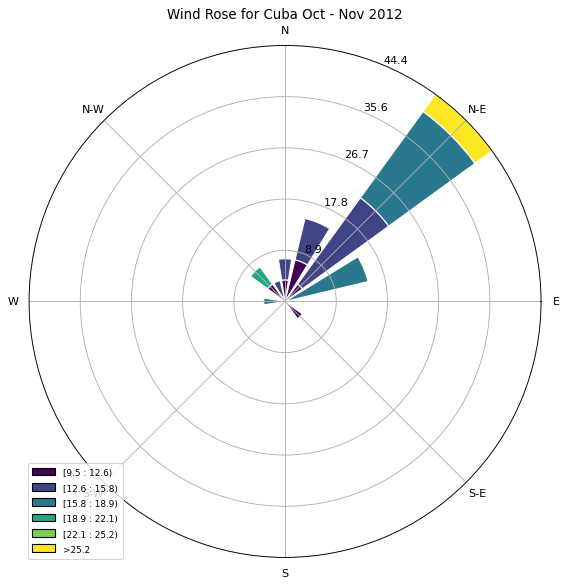

In [ ]:
plt.figure(figsize=(10, 10))
ax = WindroseAxes.from_ax()
ax.bar(cuba_data['wdir'], cuba_data['wspd'], normed=True, opening=0.8, edgecolor='white')
ax.set_title('Wind Rose for Cuba Oct - Nov 2012')
ax.set_legend()
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


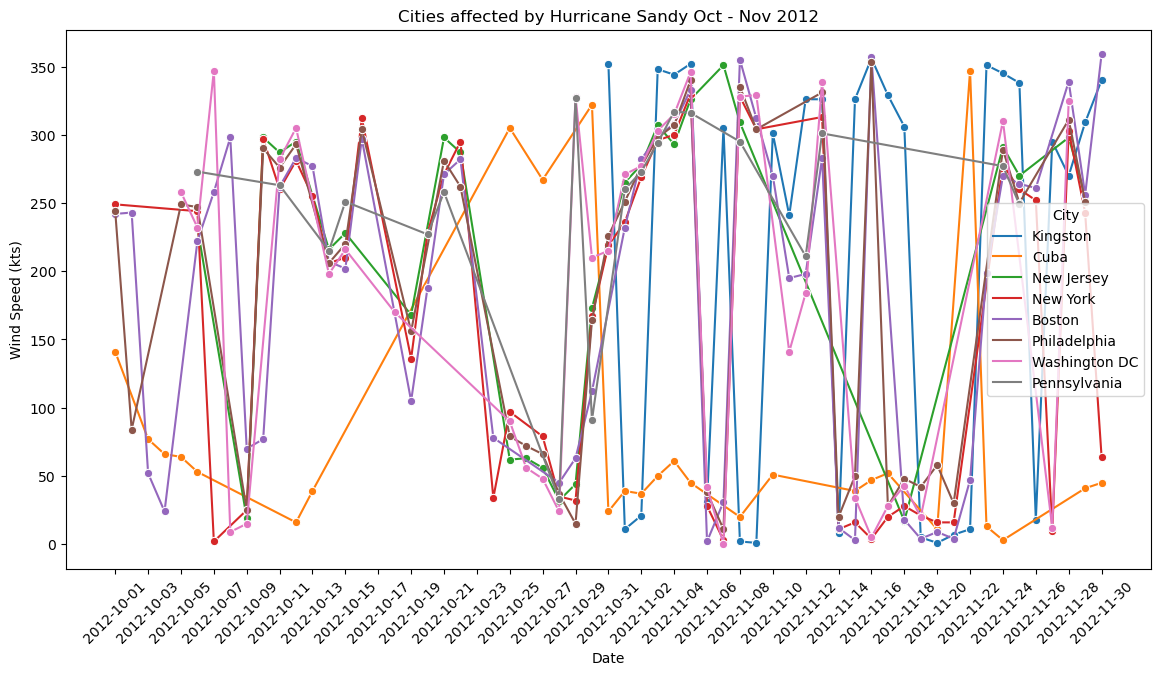

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_cities_2012, x='date', y='wdir', hue='city', marker='o')
plt.title('Cities affected by Hurricane Sandy Oct - Nov 2012')
plt.xlabel('Date')
plt.ylabel('Wind Speed (kts)')
dates = weather_cities_2012['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.legend(title='City')
plt.show()

## 2011!

In [30]:
#Weather data for 2011
#API URL and headers
url = 'https://meteostat.p.rapidapi.com/point/daily'
headers = {
   "x-rapidapi-host": 'meteostat.p.rapidapi.com',
   "x-rapidapi-key": os.getenv('x-rapidapi-key')  # Ensure this environment variable is set
}

#airports and their coordinates
airports = {
    "JFK": {"lat": 40.6413, "lon": -73.7781},  # John F. Kennedy International Airport
    "LGA": {"lat": 40.7769, "lon": -73.8740},  # LaGuardia Airport
    "EWR": {"lat": 40.6895, "lon": -74.1745},  # Newark Liberty International Airport
    "PHL": {"lat": 39.8729, "lon": -75.2437},  # Philadelphia International Airport
    "BOS": {"lat": 42.3656, "lon": -71.0096},  # Boston Logan International Airport
    "DCA": {"lat": 38.8512, "lon": -77.0402},  # Ronald Reagan Washington National Airport
    "IAD": {"lat": 38.9531, "lon": -77.4565},  # Washington Dulles International Airport
    "BWI": {"lat": 39.1754, "lon": -76.6684}   # Baltimore/Washington International Thurgood Marshall Airport
}

#date range
start_date = "2011-10-01"
end_date = "2011-11-30"
weather_data_2011 = []

for airport_code, coordinates in airports.items():
    parameters = {
        "lat": coordinates["lat"],
        "lon": coordinates["lon"],
        "start": start_date,
        "end": end_date,
        "units": "metric"
    }
    time.sleep(1)
    response = requests.get(url, headers=headers, params=parameters)

    if response.status_code == 200:
        data = response.json()
        for daily_data in data['data']:
            daily_data['airport_code'] = airport_code
            weather_data_2011.append(daily_data)
    else:
        print(f"Error fetching data for {airport_code}: {response.status_code} - {response.text}") 

#list of dictionaries to a DataFrame
weather_df_2011 = pd.DataFrame(weather_data_2011)

In [ ]:
print(weather_df_2011.head())

         date  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
0  2011-10-01  16.4  11.1  21.1   5.1   0.0  346.0  16.9  None  1004.7  None   
1  2011-10-02  14.3  10.6  18.3   0.0   0.0  187.0  18.4  None  1009.3  None   
2  2011-10-03  11.6   8.9  14.4   1.0   0.0    NaN   9.4  None  1016.6  None   
3  2011-10-04  14.1   9.4  18.3   0.0   0.0  321.0  17.6  None  1016.4  None   
4  2011-10-05  17.9  11.1  23.3   0.0   0.0  335.0  24.1  None  1018.4  None   

  airport_code  
0          JFK  
1          JFK  
2          JFK  
3          JFK  
4          JFK  


In [31]:
#Cleaning steps for 2011
#Dropping empty columns
weather_df_2011 = weather_df_2011.drop(columns=['wpgt', 'tsun'])

#Filling missing values in wspd with 0
weather_df_2011['wspd'].fillna(0, inplace=True)

#Convert date column to datetime
weather_df_2011['date'] = pd.to_datetime(weather_df_2011['date'])  

In [32]:
weather_df_2011

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,airport_code
0,2011-10-01,16.4,11.1,21.1,5.1,0.0,346.0,16.9,1004.7,JFK
1,2011-10-02,14.3,10.6,18.3,0.0,0.0,187.0,18.4,1009.3,JFK
2,2011-10-03,11.6,8.9,14.4,1.0,0.0,NaN,9.4,1016.6,JFK
3,2011-10-04,14.1,9.4,18.3,0.0,0.0,321.0,17.6,1016.4,JFK
4,2011-10-05,17.9,11.1,23.3,0.0,0.0,335.0,24.1,1018.4,JFK
...,...,...,...,...,...,...,...,...,...,...
483,2011-11-26,9.4,2.2,21.1,0.0,0.0,NaN,1.8,1023.0,BWI
484,2011-11-27,11.8,2.2,21.7,0.0,0.0,NaN,6.5,1019.8,BWI
485,2011-11-28,14.5,7.2,20.6,0.0,0.0,147.0,5.8,1018.4,BWI
486,2011-11-29,12.8,8.9,19.4,10.4,0.0,131.0,11.9,1008.7,BWI


In [ ]:
weather_df_2011.airport_code.unique()

array(['JFK', 'LGA', 'EWR', 'PHL', 'BOS', 'DCA', 'IAD', 'BWI'],
      dtype=object)

In [ ]:
# Write records stored in a dataframe to SQL database
table_name = 'weather_data_2011'
schema = 'cgn_analytics_24_3'
engine = get_engine()

if engine!=None:
    try:
        weather_df_2011.to_sql(table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # your class schema
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The weather_data_2011 table was imported successfully.


In [ ]:
weather_df_2011.to_csv('data/weather_sandy_data.csv', index=False)

## Plotting

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


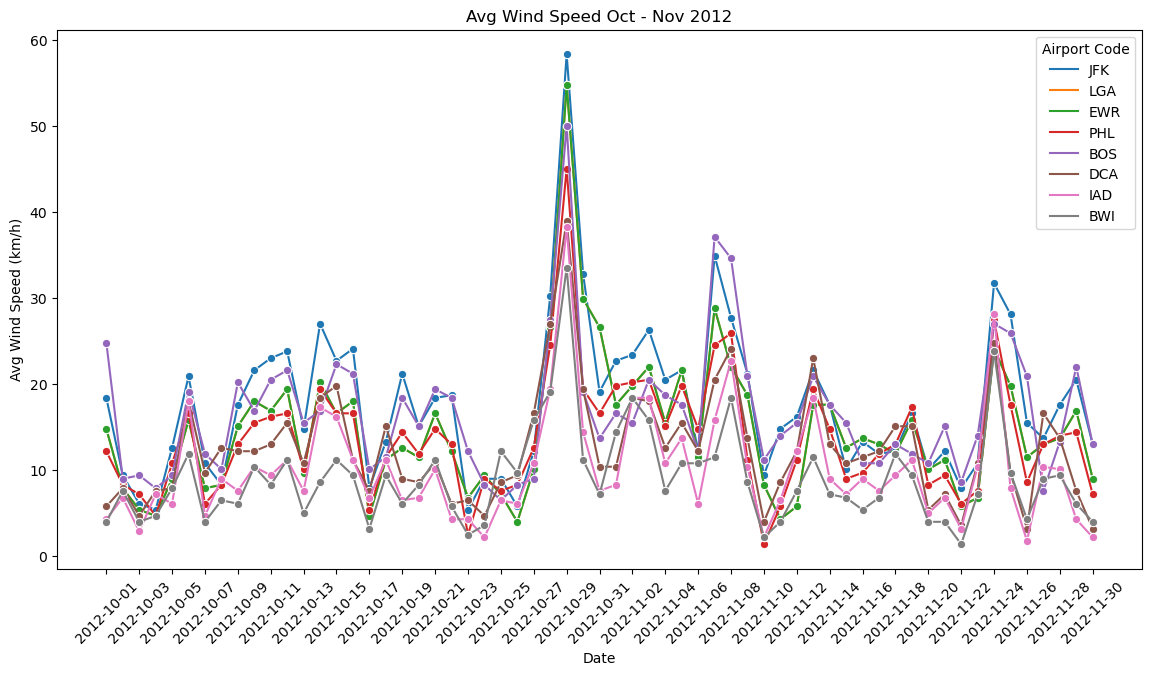

In [72]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_df_2012, x='date', y='wspd', hue='airport_code', marker='o')
plt.title('Avg Wind Speed Oct - Nov 2012')
plt.xlabel('Date')
plt.ylabel('Avg Wind Speed (km/h)')
dates = weather_df_2012['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.legend(title='Airport Code')
plt.show()

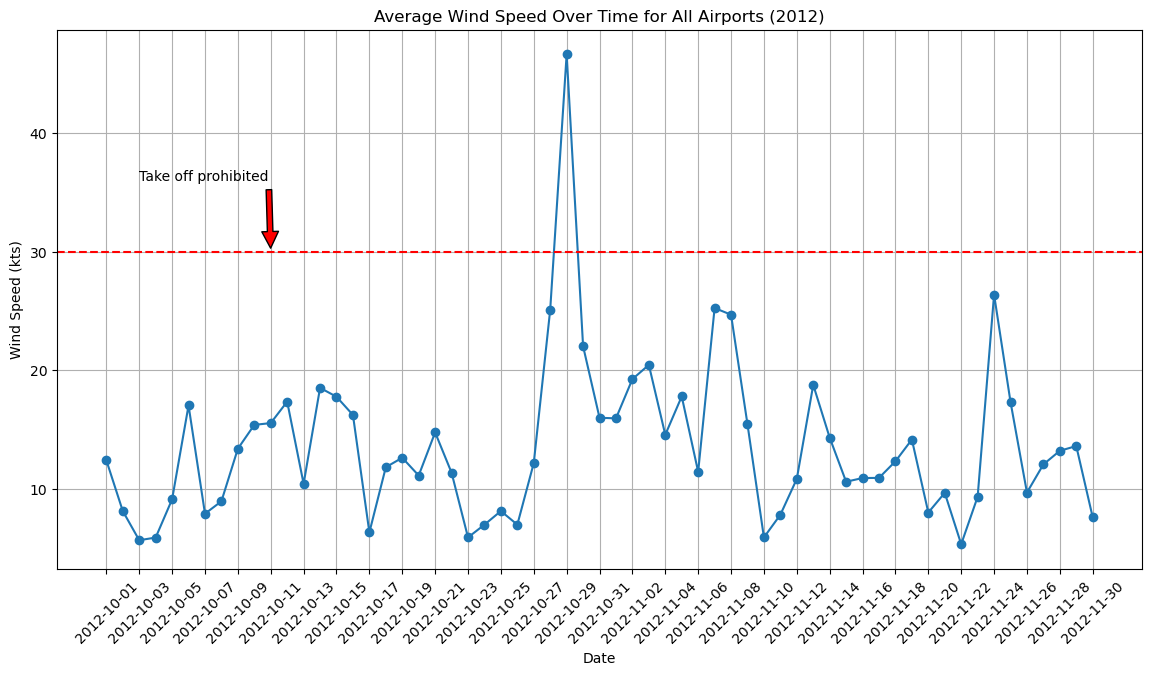

In [62]:
plt.figure(figsize=(14, 7))
plt.plot(average_wind_speed['date'], average_wind_speed['wspd'], marker='o')
plt.axhline(y=30, color='r', linestyle='--', label='30 kts')
plt.title('Average Wind Speed Over Time for All Airports (2012)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (kts)')
plt.xticks(dates[::2], rotation=45)
plt.annotate('Take off prohibited',
             xy=(average_wind_speed['date'][10], 30), 
             xytext=(average_wind_speed['date'][2], 36),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.grid(True)
plt.show()

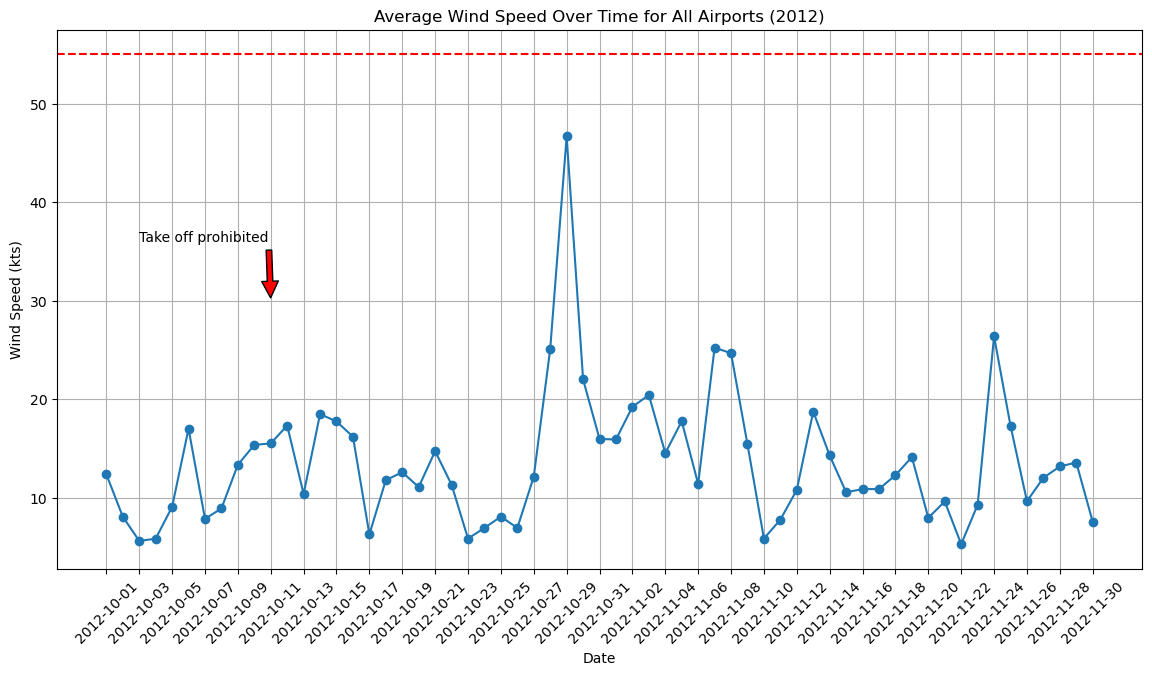

In [67]:
plt.figure(figsize=(14, 7))
plt.plot(average_wind_speed['date'], average_wind_speed['wspd'], marker='o')
plt.axhline(y=55, color='r', linestyle='--', label='55 km/h')
plt.title('Average Wind Speed Over Time for All Airports (2012)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (kts)')
plt.xticks(dates[::2], rotation=45)
plt.annotate('Take off prohibited',
             xy=(average_wind_speed['date'][10], 30), 
             xytext=(average_wind_speed['date'][2], 36),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_df_2012, x='date', y='wspd', hue='airport_code', marker='o')
plt.axhline(y=30, color='r', linestyle='--', label='30 kts')
plt.title('Wind Speed Oct - Nov 2012')
plt.xlabel('Date')
plt.ylabel('Wind Speed (kts)')
dates = weather_df_2012['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.legend(title='Airport Code')
plt.annotate('Take off prohibited', xy=(20, 30), xytext=(18, 36),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


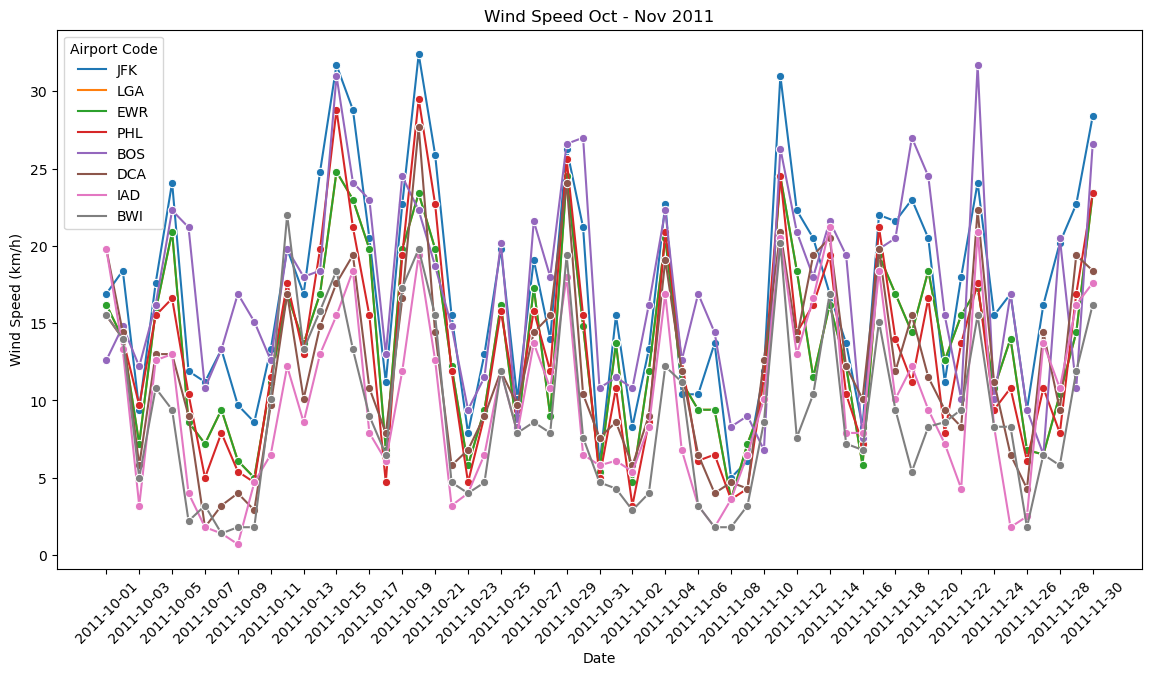

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_df_2011, x='date', y='wspd', hue='airport_code', marker='o')
plt.title('Wind Speed Oct - Nov 2011')
plt.xlabel('Date')
plt.ylabel('Wind Speed (km/h)')
plt.legend(title='Airport Code')
dates = weather_df_2011['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


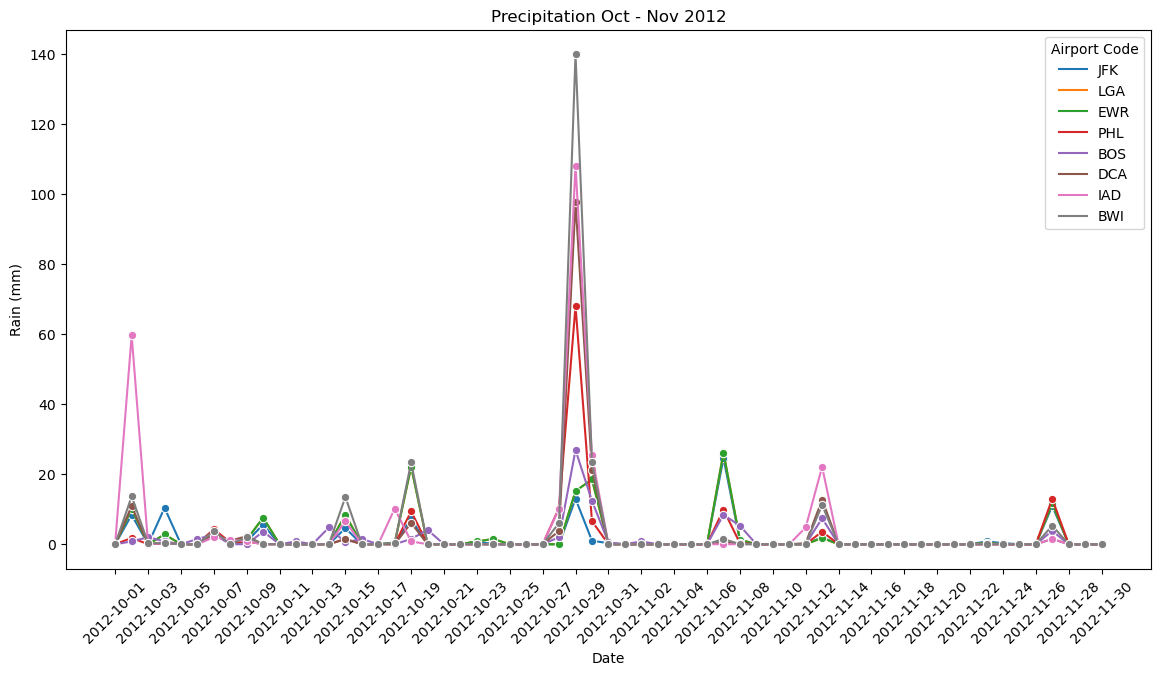

In [63]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_df_2012, x='date', y='prcp', hue='airport_code', marker='o')
plt.title('Precipitation Oct - Nov 2012')
plt.xlabel('Date')
plt.ylabel('Rain (mm)')
plt.legend(title='Airport Code')
dates = weather_df_2012['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


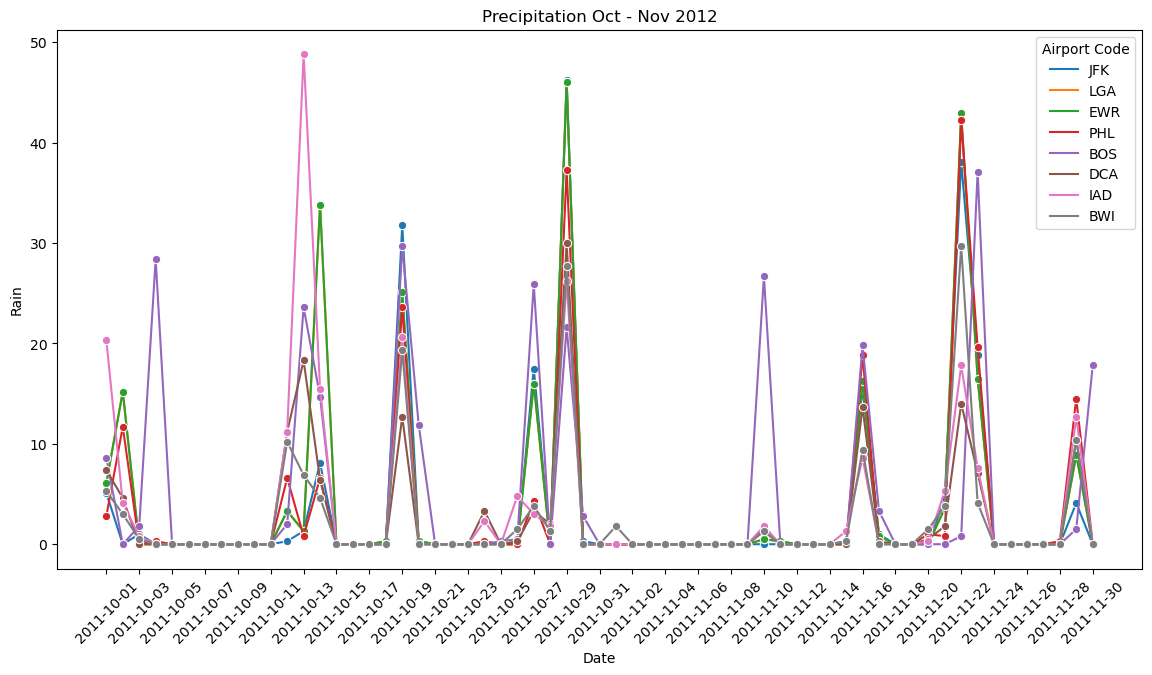

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_df_2011, x='date', y='prcp', hue='airport_code', marker='o')
plt.title('Precipitation Oct - Nov 2012')
plt.xlabel('Date')
plt.ylabel('Rain')
plt.legend(title='Airport Code')
dates = weather_df_2011['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


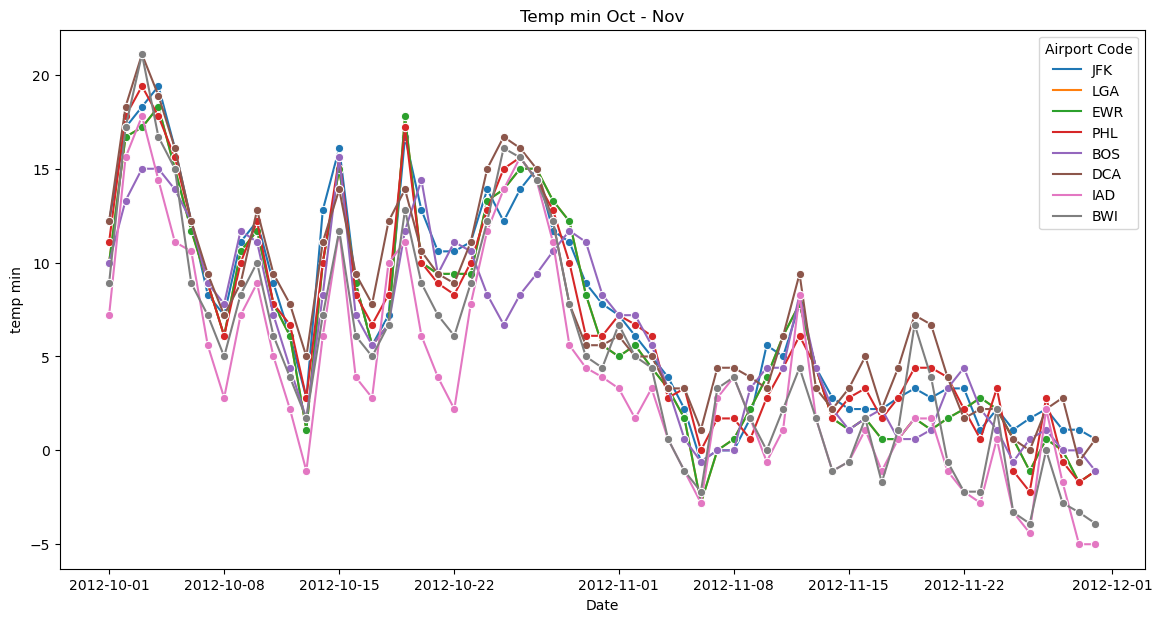

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_df_2012, x='date', y='tmin', hue='airport_code', marker='o')
plt.title('Temp min Oct - Nov')
plt.xlabel('Date')
plt.ylabel('temp min')
plt.legend(title='Airport Code')
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


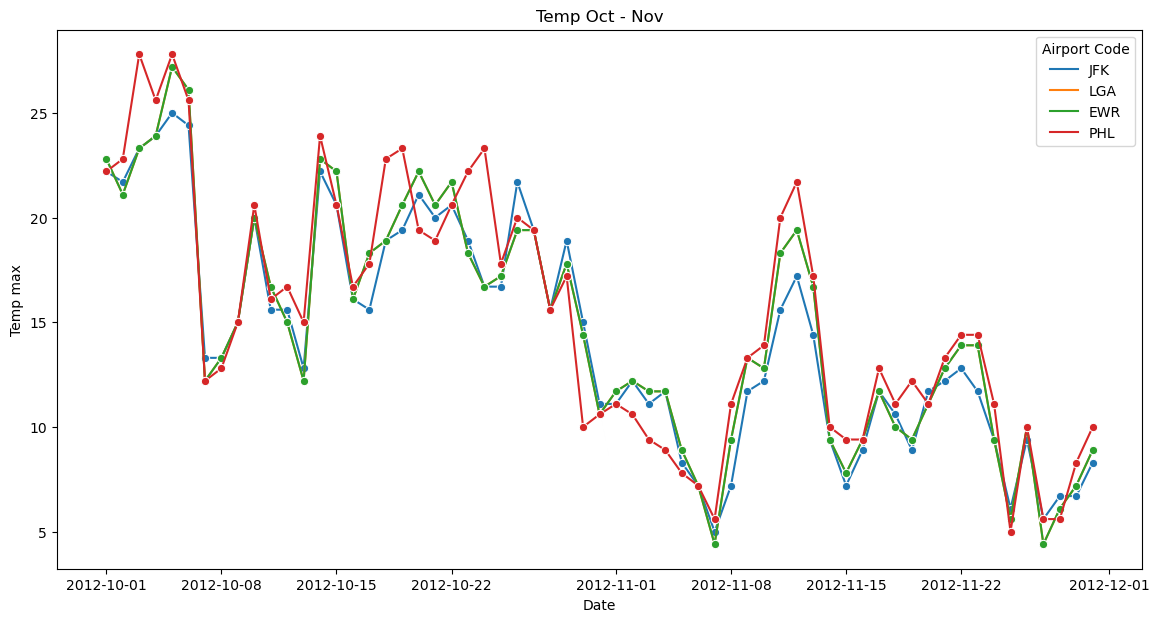

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_df, x='date', y='tmax', hue='airport_code', marker='o')
plt.title('Temp Oct - Nov')
plt.xlabel('Date')
plt.ylabel('Temp max')
plt.legend(title='Airport Code')
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


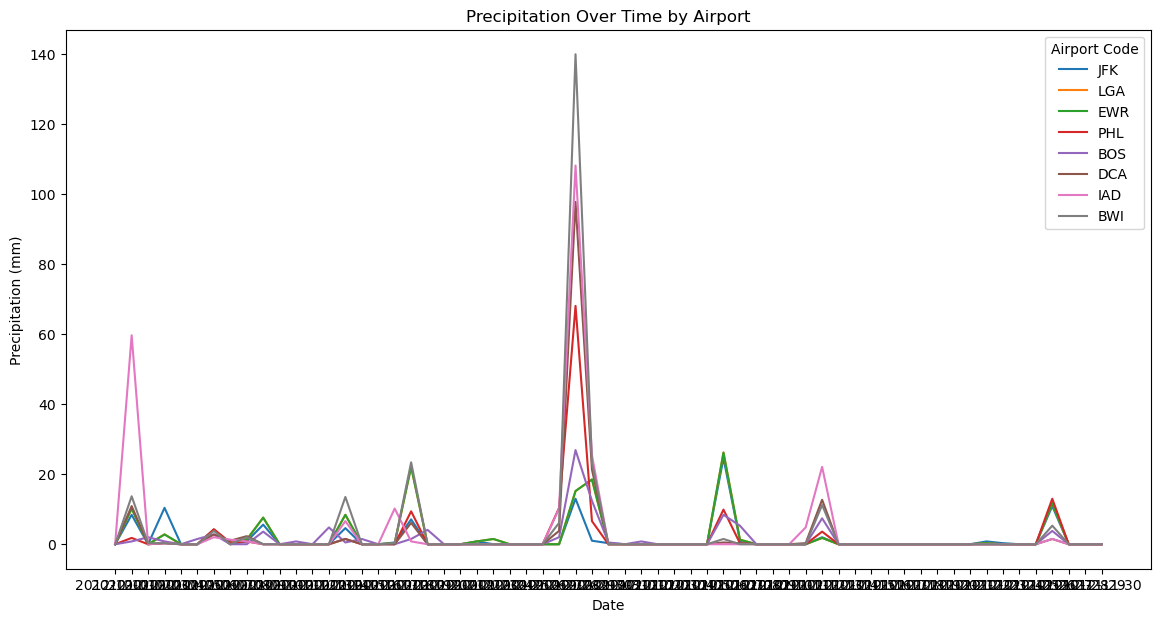

In [ ]:
# Plot precipitation over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_df_2012, x='date', y='prcp', hue='airport_code')
plt.title('Precipitation Over Time by Airport')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend(title='Airport Code')
plt.show()

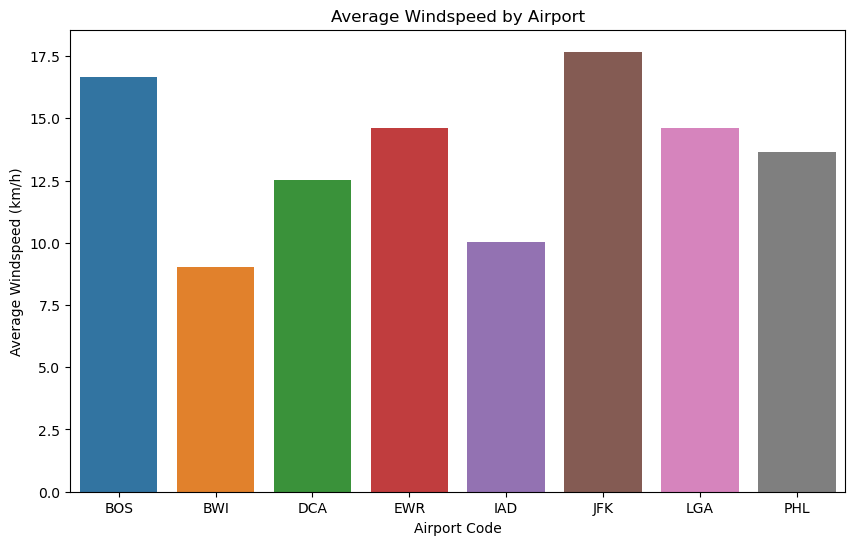

In [ ]:
# Aggregate the data by airport to get average windspeed and precipitation
agg_data = weather_df_2012.groupby('airport_code').agg({'wspd': 'mean','prcp': 'mean'}).reset_index()

# Plot average windspeed by airport
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_data, x='airport_code', y='wspd')
plt.title('Average Windspeed by Airport')
plt.xlabel('Airport Code')
plt.ylabel('Average Windspeed (km/h)')
plt.show()


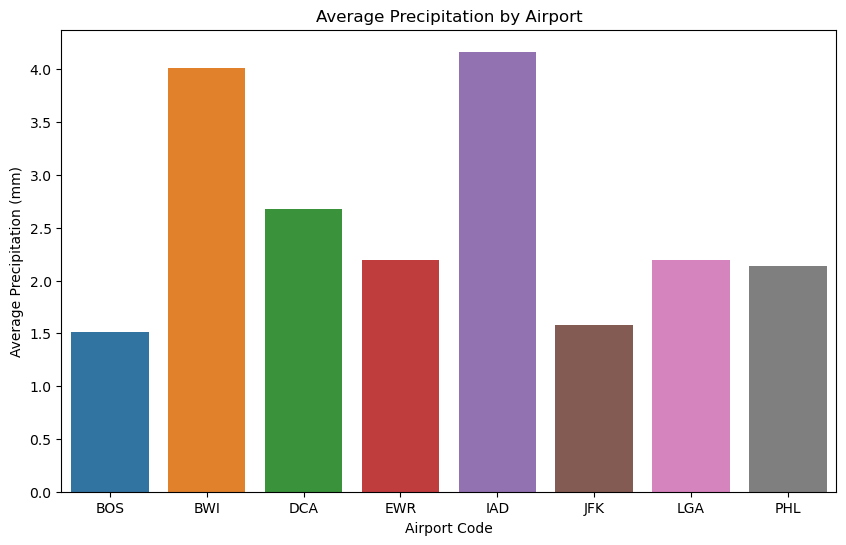

In [ ]:
# Plot average precipitation by airport
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_data, x='airport_code', y='prcp')
plt.title('Average Precipitation by Airport')
plt.xlabel('Airport Code')
plt.ylabel('Average Precipitation (mm)')
plt.show()

In [35]:
from sql_functions import get_dataframe
import sqlalchemy

In [36]:
flights_data = 'SELECT * FROM cgn_analytics_24_3.flights_oct_nov_2012_sandy'
flights_data

'SELECT * FROM cgn_analytics_24_3.flights_oct_nov_2012_sandy'

In [37]:
get_dataframe(flights_data)

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
0,2012-10-01,933.0,900,33.0,1305.0,1205,60.0,AA,N320AA,1,JFK,LAX,317.0,392.0,2475.0,0,0
1,2012-10-02,906.0,900,6.0,1200.0,1205,-5.0,AA,N319AA,1,JFK,LAX,328.0,354.0,2475.0,0,0
2,2012-10-03,900.0,900,0.0,1225.0,1205,20.0,AA,N319AA,1,JFK,LAX,340.0,385.0,2475.0,0,0
3,2012-10-04,853.0,900,-7.0,1205.0,1205,0.0,AA,N325AA,1,JFK,LAX,336.0,372.0,2475.0,0,0
4,2012-10-05,853.0,900,-7.0,1236.0,1205,31.0,AA,N325AA,1,JFK,LAX,368.0,403.0,2475.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234768,2012-11-30,2114.0,1942,92.0,2219.0,2101,78.0,YV,N511MJ,3786,PHL,ORD,104.0,125.0,678.0,0,0
234769,2012-11-30,1534.0,1445,49.0,1648.0,1558,50.0,YV,N510MJ,3787,PHL,ORD,107.0,134.0,678.0,0,0
234770,2012-11-30,1014.0,1023,-9.0,1115.0,1126,-11.0,YV,N505MJ,3801,RDU,IAD,46.0,61.0,224.0,0,0
234771,2012-11-30,1426.0,1426,0.0,1540.0,1545,-5.0,YV,N505MJ,3783,SYR,IAD,49.0,74.0,296.0,0,0


In [38]:
df_cancellations = get_dataframe('''select flight_date as date, origin as airport_code, cancellation_percentage 
                   from cgn_analytics_24_3.cancellations_per_day_2012_sandy''')

In [39]:
df_cancellations

,date,airport_code,cancellation_percentage
0,2012-10-01,DCA,0.000000
1,2012-10-01,EWR,0.000000
2,2012-10-01,BWI,0.000000
3,2012-10-01,LGA,1.633987
4,2012-10-01,IAD,0.873362
...,...,...,...
483,2012-11-30,IAD,0.000000
484,2012-11-30,JFK,0.000000
485,2012-11-30,LGA,0.696864
486,2012-11-30,EWR,0.270270


In [40]:
df_weather = get_dataframe('select date, tavg, tmin, tmax, prcp, wspd, airport_code from cgn_analytics_24_3.weather_data_2012')

In [41]:
df_weather

,date,tavg,tmin,tmax,prcp,wspd,airport_code
0,2012-10-01,17.1,12.2,22.2,0.0,18.4,JFK
1,2012-10-02,18.9,17.2,21.7,8.4,9.4,JFK
2,2012-10-03,20.3,18.3,23.3,0.0,6.1,JFK
3,2012-10-04,20.8,19.4,23.9,10.4,5.4,JFK
4,2012-10-05,20.7,16.1,25.0,0.0,12.6,JFK
...,...,...,...,...,...,...,...
483,2012-11-26,3.9,-3.9,12.2,0.0,4.3,BWI
484,2012-11-27,4.0,0.0,5.6,5.3,9.0,BWI
485,2012-11-28,3.2,-2.8,7.8,0.0,9.4,BWI
486,2012-11-29,2.6,-3.3,9.4,0.0,6.1,BWI


In [42]:
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [ ]:
weather_cancellations = pd.merge(df_cancellations, df_weather, on=['date','airport_code'], how='inner')
weather_cancellations

,date,airport_code,cancellation_percentage,tavg,tmin,tmax,prcp,wspd
0,2012-10-01,DCA,0.000000,16.9,12.2,22.2,0.0,5.8
1,2012-10-01,EWR,0.000000,16.6,10.0,22.8,0.0,14.8
2,2012-10-01,BWI,0.000000,15.6,8.9,22.2,0.0,4.0
3,2012-10-01,LGA,1.633987,16.6,10.0,22.8,0.0,14.8
4,2012-10-01,IAD,0.873362,14.3,7.2,21.1,0.3,4.3
...,...,...,...,...,...,...,...,...
483,2012-11-30,IAD,0.000000,2.4,-5.0,12.2,0.0,2.2
484,2012-11-30,JFK,0.000000,4.7,0.6,8.3,0.0,13.0
485,2012-11-30,LGA,0.696864,4.6,-1.1,8.9,0.0,9.0
486,2012-11-30,EWR,0.270270,4.6,-1.1,8.9,0.0,9.0


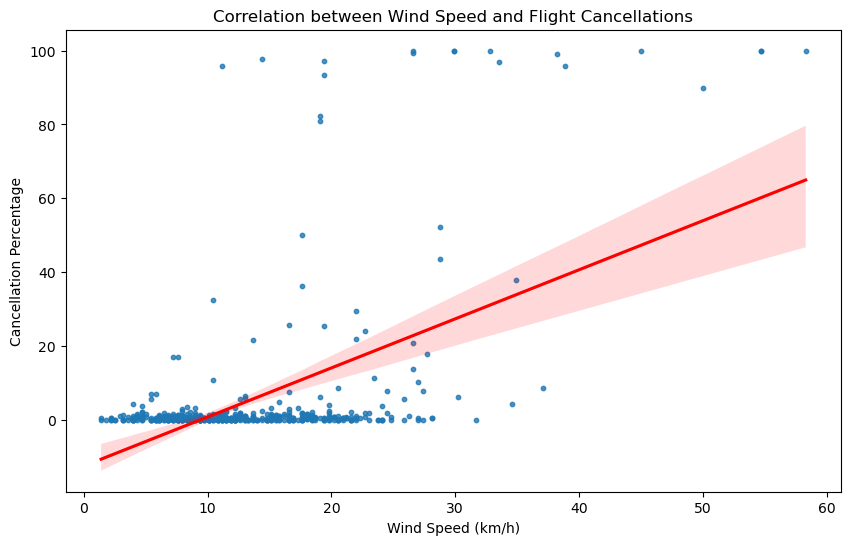

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='wspd', y='cancellation_percentage', data=weather_cancellations, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Correlation between Wind Speed and Flight Cancellations')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Cancellation Percentage')
plt.show()

Airport with the highest cancellations:
airport_code                      LGA
cancellation_percentage    487.416394
Name: 6, dtype: object


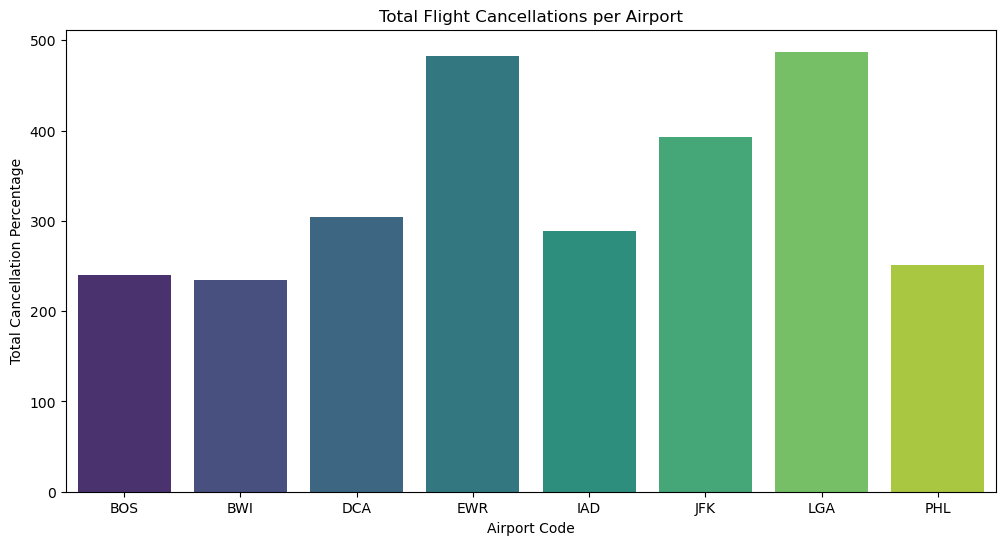

In [ ]:
# Calculate the total cancellations per airport
total_cancellations = weather_cancellations.groupby('airport_code')['cancellation_percentage'].sum().reset_index()

# Identify the airport with the highest cancellations
max_cancellations_airport = total_cancellations.loc[total_cancellations['cancellation_percentage'].idxmax()]

print("Airport with the highest cancellations:")
print(max_cancellations_airport)

# Bar plot to visualize cancellations per airport
plt.figure(figsize=(12, 6))
sns.barplot(x='airport_code', y='cancellation_percentage', data=total_cancellations, palette='viridis')
plt.title('Total Flight Cancellations per Airport')
plt.xlabel('Airport Code')
plt.ylabel('Total Cancellation Percentage')
plt.show()

In [ ]:
date_filtered_df = weather_cancellations[(weather_cancellations['date'] >= '2012-10-25') & (weather_cancellations['date'] <= '2012-10-30')]

# Calculate the total cancellations per airport for the filtered dates
filtered_total_cancellations = date_filtered_df.groupby('airport_code')['cancellation_percentage'].sum().reset_index()

# Identify the airport with the highest cancellations in the filtered dates
max_filtered_cancellations_airport = filtered_total_cancellations.loc[filtered_total_cancellations['cancellation_percentage'].idxmax()]

print("Airport with the highest cancellations between 27th and 30th October 2012:")
print(max_filtered_cancellations_airport)

Airport with the highest cancellations between 27th and 30th October 2012:
airport_code                      IAD
cancellation_percentage    225.414999
Name: 4, dtype: object


In [43]:
df_ = get_dataframe('''select flight_date as date, origin as airport_code, cancellation_percentage 
                   from cgn_analytics_24_3.cancellations_per_day_2012_sandy''')

In [44]:
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [45]:
weather_cancellations = pd.merge(df_cancellations, df_weather, on=['date','airport_code'], how='inner')
weather_cancellations

,date,airport_code,cancellation_percentage,tavg,tmin,tmax,prcp,wspd
0,2012-10-01,DCA,0.000000,16.9,12.2,22.2,0.0,5.8
1,2012-10-01,EWR,0.000000,16.6,10.0,22.8,0.0,14.8
2,2012-10-01,BWI,0.000000,15.6,8.9,22.2,0.0,4.0
3,2012-10-01,LGA,1.633987,16.6,10.0,22.8,0.0,14.8
4,2012-10-01,IAD,0.873362,14.3,7.2,21.1,0.3,4.3
...,...,...,...,...,...,...,...,...
483,2012-11-30,IAD,0.000000,2.4,-5.0,12.2,0.0,2.2
484,2012-11-30,JFK,0.000000,4.7,0.6,8.3,0.0,13.0
485,2012-11-30,LGA,0.696864,4.6,-1.1,8.9,0.0,9.0
486,2012-11-30,EWR,0.270270,4.6,-1.1,8.9,0.0,9.0


### diversions

In [46]:
diversions_df = get_dataframe('''select *, flight_date as date
                   from cgn_analytics_24_3.diverted_per_day_2012_sandy''')

In [47]:
diversions_df['date'] = pd.to_datetime(diversions_df['date'])

In [48]:
diversions_2012 = diversions_df.drop(columns=['flight_date'])

In [49]:
diversions_2012

,dest,total_flights,total_diverted,diverted_percentage,date
0,DCA,222,1,0.450450,2012-10-01
1,EWR,370,0,0.000000,2012-10-01
2,BWI,295,0,0.000000,2012-10-01
3,LGA,304,1,0.328947,2012-10-01
4,IAD,232,0,0.000000,2012-10-01
...,...,...,...,...,...
483,IAD,208,0,0.000000,2012-11-30
484,JFK,259,0,0.000000,2012-11-30
485,LGA,287,0,0.000000,2012-11-30
486,EWR,371,0,0.000000,2012-11-30


In [52]:
daily_avg_diversions = diversions_2012.groupby('date')['total_diverted'].mean().reset_index()
daily_avg_diversions

,date,total_diverted
0,2012-10-01,0.250
1,2012-10-02,2.250
2,2012-10-03,1.125
3,2012-10-04,0.375
4,2012-10-05,0.250
...,...,...
56,2012-11-26,0.000
57,2012-11-27,0.125
58,2012-11-28,0.000
59,2012-11-29,0.000


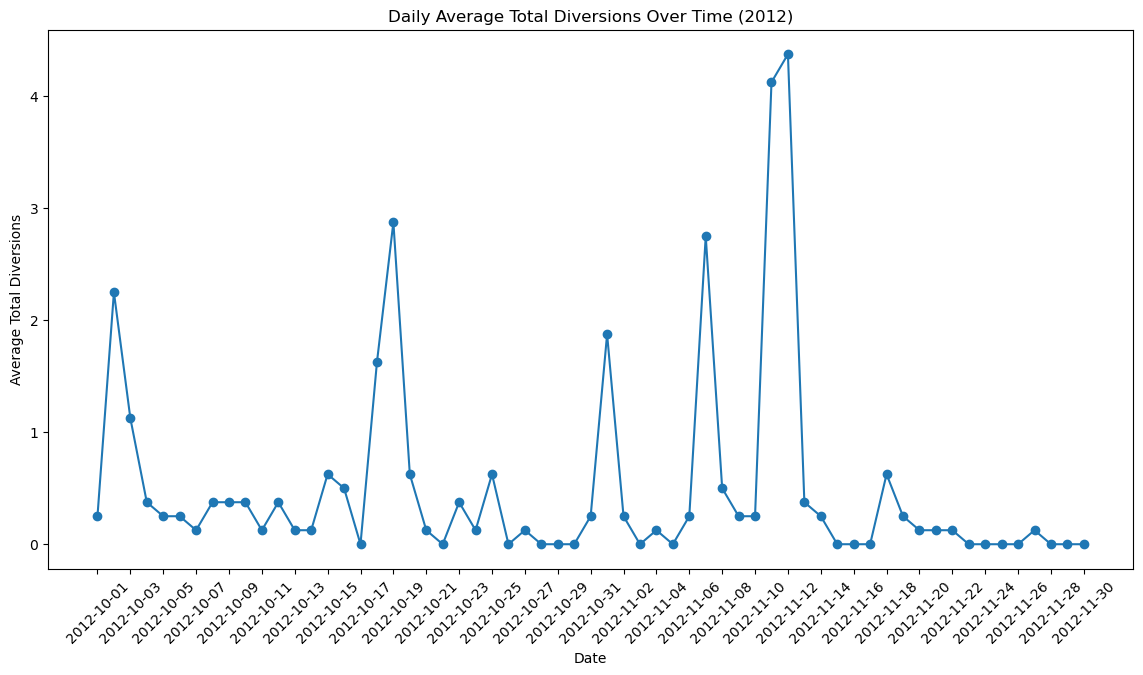

In [73]:
plt.figure(figsize=(14, 7))
plt.plot(daily_avg_diversions['date'], daily_avg_diversions['total_diverted'], marker='o')
plt.title('Daily Average Total Diversions Over Time (2012)')
plt.xlabel('Date')
plt.ylabel('Average Total Diversions')
dates = weather_df_2012['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.grid(False)
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


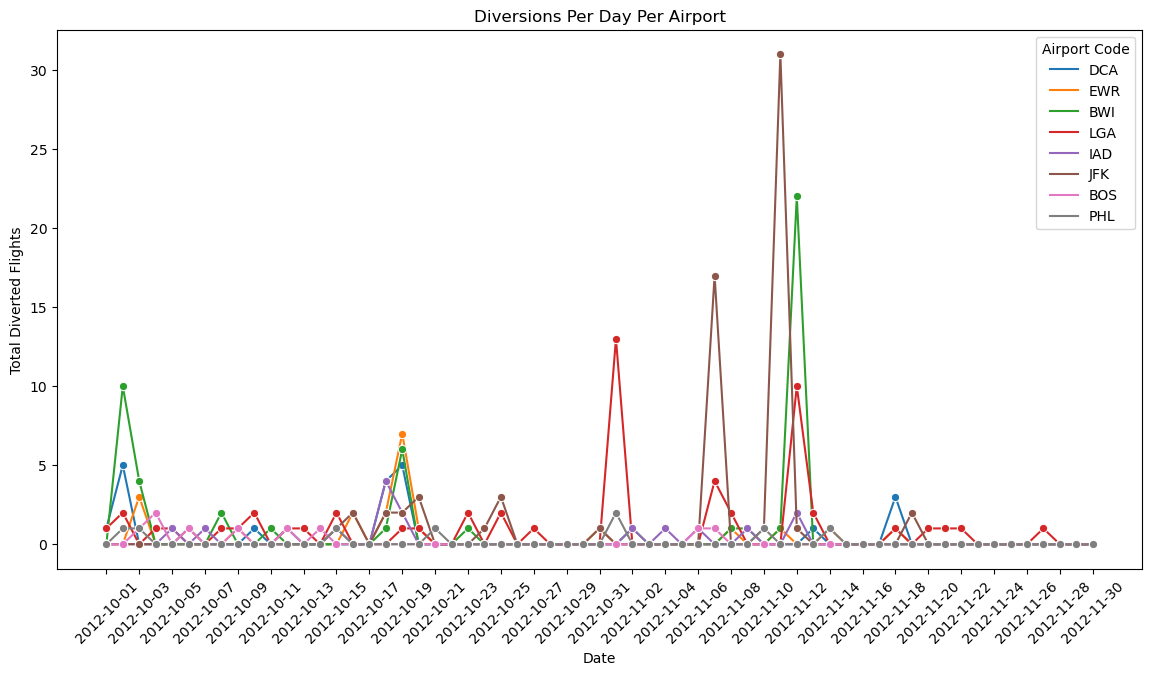

In [50]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=diversions_2012, x='date', y='total_diverted', hue='dest', marker='o')
plt.title('Diversions Per Day Per Airport')
plt.xlabel('Date')
plt.ylabel('Total Diverted Flights')
plt.legend(title='Airport Code')
dates = diversions_2012['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.show()

/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zahra/miniconda3/envs/nf_sql/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


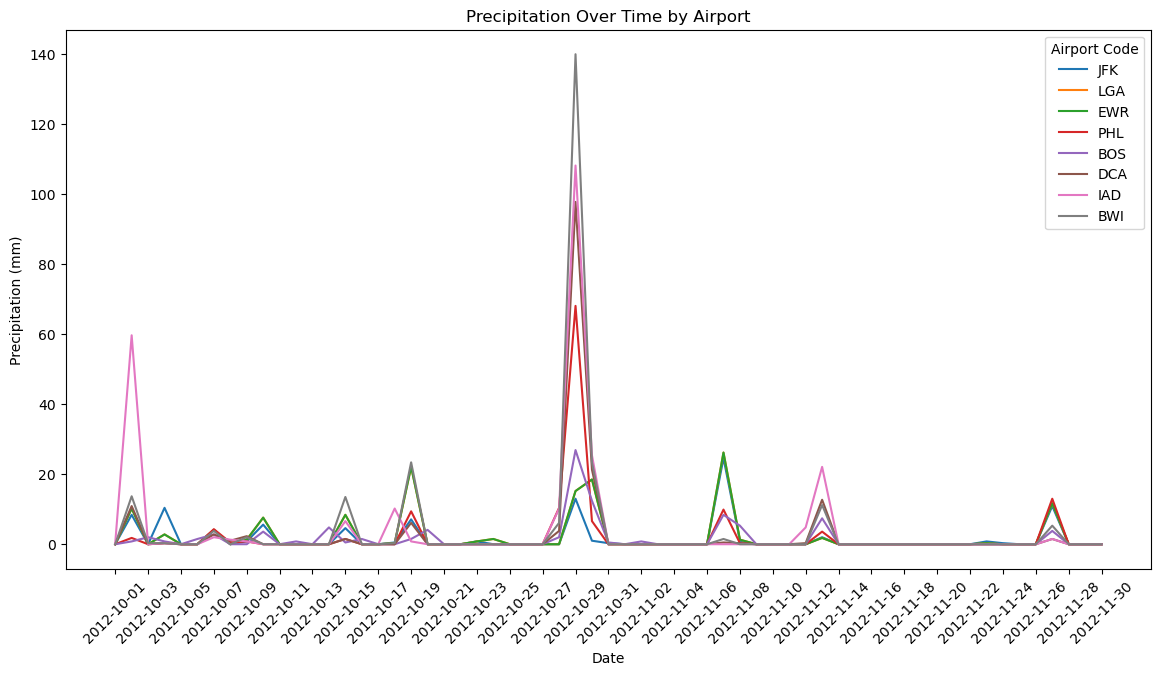

In [ ]:
# Plot precipitation over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_df_2012, x='date', y='prcp', hue='airport_code')
plt.title('Precipitation Over Time by Airport')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend(title='Airport Code')
dates = weather_df_2012['date'].unique()
plt.xticks(dates[::2], rotation=45)
plt.show()